# Group Project Report
#### Using KNN Classification to Predict Movie Genre

**Group Number:** 24

**Group Members:** Sienna Muller, Pascal Lo, Matthew Haryanto, Juan Pablo Villalobos

### Introduction:

For our project, we retrieved a GitHub dataset containing information on some of the most popular Hollywood Movies from 2007 - 2013. To confirm the reliability of the data, we traced its origins and found that the data came from a project in which several researchers hand-compiled information from a variety of sources across the internet (IMDb, RottenTomatoes, etc.). This project can be found at http://bit.ly/hollywoodbudgets.

The dataset contains information on 970 films, represented by variables across 16 columns. Both categorical (e.g. studio, genre) and numerical (e.g. rotten tomatoes score, budget) variables are present in the dataset. 

### Our question: 

**How do the opening weekend profits, budget, and profitability predict the genre of a film when using a knn-classification algorithm?**

### Preliminary Exploratory Data Analysis:

In [2]:
# below are all of the libraries that must be imported for this project

library(tidyverse)
library(gridExtra)
library(rvest) 
library(repr)
library(tidymodels)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘rvest’


The following object is masked from ‘package:readr’:

    guess_encoding


── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔

In [3]:
# reading dataset from the web into R
options(repr.matrix.max.rows = 12)

url <- "https://raw.githubusercontent.com/reisanar/datasets/master/HollywoodMovies.csv"

hollywood_movies <- read_csv(url)
hollywood_movies

Rows: 970 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (4): Movie, LeadStudio, Story, Genre
dbl (12): RottenTomatoes, AudienceScore, TheatersOpenWeek, OpeningWeekend, B...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Movie,LeadStudio,RottenTomatoes,AudienceScore,Story,Genre,TheatersOpenWeek,OpeningWeekend,BOAvgOpenWeekend,DomesticGross,ForeignGross,WorldGross,Budget,Profitability,OpenProfit,Year
<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Spider-Man 3,Sony,61,54,Metamorphosis,Action,4252,151.1,35540,336.53,554.34,890.87,258,345.30,58.57,2007
Shrek the Third,Paramount,42,57,Quest,Animation,4122,121.6,29507,322.72,476.24,798.96,160,499.35,76.00,2007
Transformers,Paramount,57,89,Monster Force,Action,4011,70.5,17577,319.25,390.46,709.71,150,473.14,47.00,2007
Pirates of the Caribbean: At World's End,Disney,45,74,Rescue,Action,4362,114.7,26302,309.42,654.00,963.42,300,321.14,38.23,2007
Harry Potter and the Order of the Phoenix,Warner Bros,78,82,Quest,Adventure,4285,77.1,17998,292.00,647.88,939.89,150,626.59,51.40,2007
I Am Legend,Warner Bros,69,69,Quest,Thriller,3606,77.2,21411,256.39,328.96,585.35,150,390.23,51.47,2007
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
The Butler,Weinstein,73,79,NA,NA,2933,24.64,8400,116.63,51.11,167.74,30,559.14,82.13,2013
The Canyons,IFC,22,NA,NA,NA,1,0.01,13351,0.06,0.14,0.19,NA,77.21,NA,2013


**Table 1**. Reading the dataset from the web, prior to tidying and wrangling.

With the testing data, we want to make some adjustments. These includes removing the NAs in our dataset. We can do that by filtering each column using the 'is.na' function. Then, we want to group some of the Genres together to balance the count each Genre for balance.

In [5]:
# cleaning/tidying data for further analysis

hollywood_movies_tidy <- hollywood_movies |>
    select(Genre, OpeningWeekend, Budget, Profitability) |> # selecting the important columns
    filter(!is.na(Genre), !is.na(OpeningWeekend), !is.na(Budget), !is.na(Profitability)) |> # removes the NA
    filter(Genre != 'Biography', Genre != 'Documentary') |>
    mutate(Genre = case_when(
        Genre %in% c('Action', 'Adventure', 'Fantasy') ~ 'Action',
        Genre %in% c('Romance', 'Drama') ~ 'Romance',
        Genre %in% c('Horror', 'Thriller', 'Mystery', 'Crime') ~ 'Horror',
        Genre %in% c('Comedy', 'Musical', 'Animation') ~ 'Comedy')) |>
    mutate(Genre = as_factor(Genre)) |>
    arrange(Genre)
   
hollywood_movies_tidy

Genre,OpeningWeekend,Budget,Profitability
<fct>,<dbl>,<dbl>,<dbl>
Action,151.1,258,345.30
Action,70.5,150,473.14
Action,114.7,300,321.14
Action,77.1,150,626.59
Action,70.9,65,701.64
Action,49.1,140,184.30
⋮,⋮,⋮,⋮
Romance,14.52,66,269.07
Romance,16.84,38,308.14


In [6]:
#split the data into training and testing data for knn classification

hollywood_split <- initial_split(hollywood_movies_tidy, prop = 0.75, strata = Genre)
hollywood_training <- training(hollywood_split)
hollywood_testing <- testing(hollywood_split)

**Table 2**. The tidy and wrangled data set, with the desired genre categories and columns selected to be values for knn classification.

In [9]:
# summarizing the data into a table

hollywood_movies_summary <- hollywood_movies_tidy |>
    group_by(Genre) |>
    summarize(OpeningWeekendAvg = mean(OpeningWeekend), BudgetAvg = mean(Budget), ProfitabilityAvg = mean(Profitability), count = n())
hollywood_movies_summary

Genre,OpeningWeekendAvg,BudgetAvg,ProfitabilityAvg,count
<fct>,<dbl>,<dbl>,<dbl>,<int>
Action,31.97255,84.69100,270.1140,200
Comedy,20.66086,53.80717,322.9086,223
Horror,19.06190,36.89524,558.2477,105
Romance,13.53809,30.43879,442.1393,116


**Table 3**. Provides a summary of the 4 chosen genres and the average (mean) of the three values to be used for knn classification: opening weekend gross, budget, and profitability (in millions).

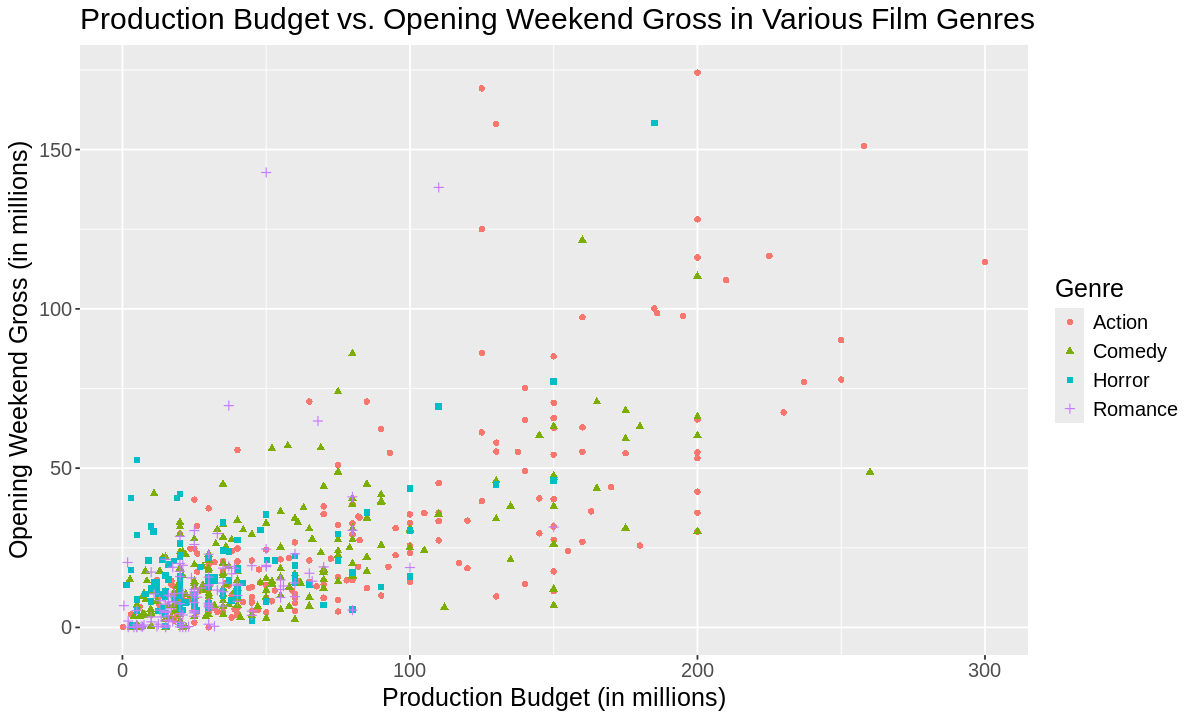

In [10]:
# visualizing the dataset 

options(repr.plot.width = 10, repr.plot.height = 6) 

hollywood_plot_opening <- hollywood_movies_tidy |>
    ggplot(aes(x = Budget, y = OpeningWeekend, colour = Genre, shape = Genre)) +
    geom_point() +
    labs(x = "Production Budget (in millions)", y = "Opening Weekend Gross (in millions)",) +
    ggtitle("Production Budget vs. Opening Weekend Gross in Various Film Genres") +
    theme(text = element_text(size = 15))

hollywood_plot_opening

**Figure 1**. The scatterplot above provides a visualization of the production budget vs. the opening weekend gross depending on the genre of the film. This visualization is relevant to our question, as it relates two of our values that will be used in the knn classification algorithm to predict the genre.

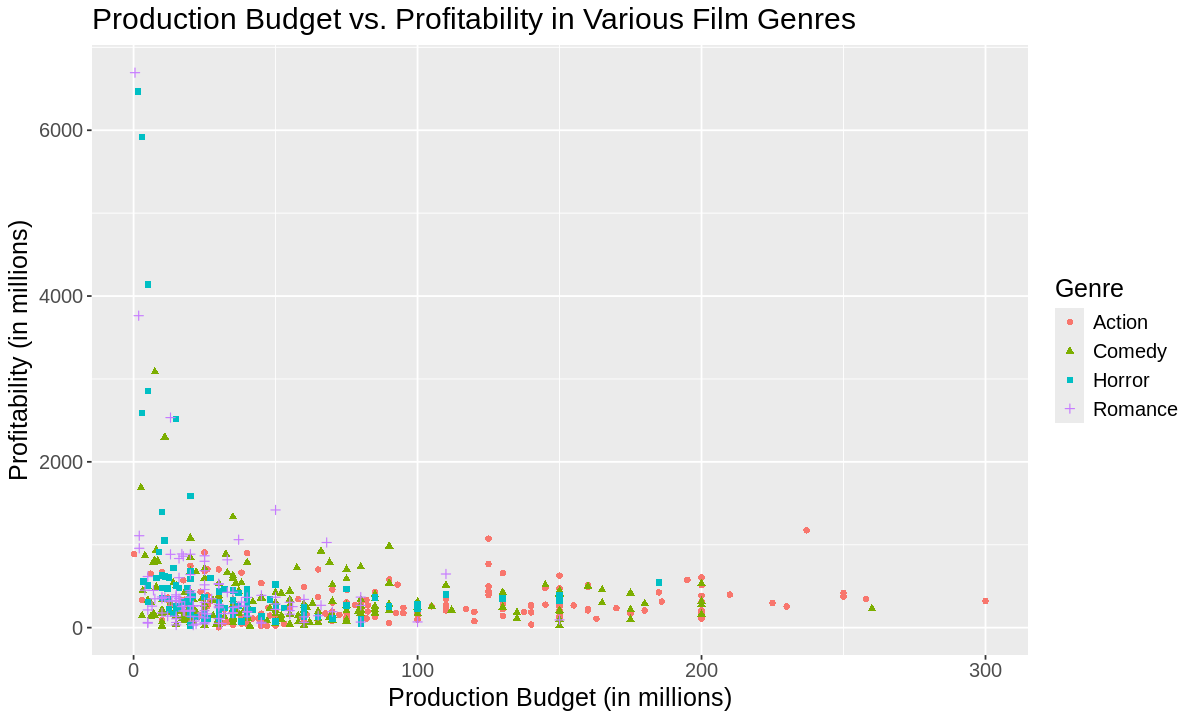

In [11]:
options(repr.plot.width = 10, repr.plot.height = 6) 

hollywood_plot_profit <- hollywood_movies_tidy |>
    ggplot(aes(x = Budget, y = Profitability, colour = Genre, shape = Genre)) +
    geom_point() +
    labs(x = "Production Budget (in millions)", y = "Profitability (in millions)",) +
    ggtitle("Production Budget vs. Profitability in Various Film Genres") +
    theme(text = element_text(size = 15))

hollywood_plot_profit

**Figure 2**. The scatterplot above provides a visualization of the production budget vs. the profitability depending on the genre of the Hollywood film. This visualization is relevant to our question, as it relates two of our values that will be used in the knn classification algorithm to predict the genre.

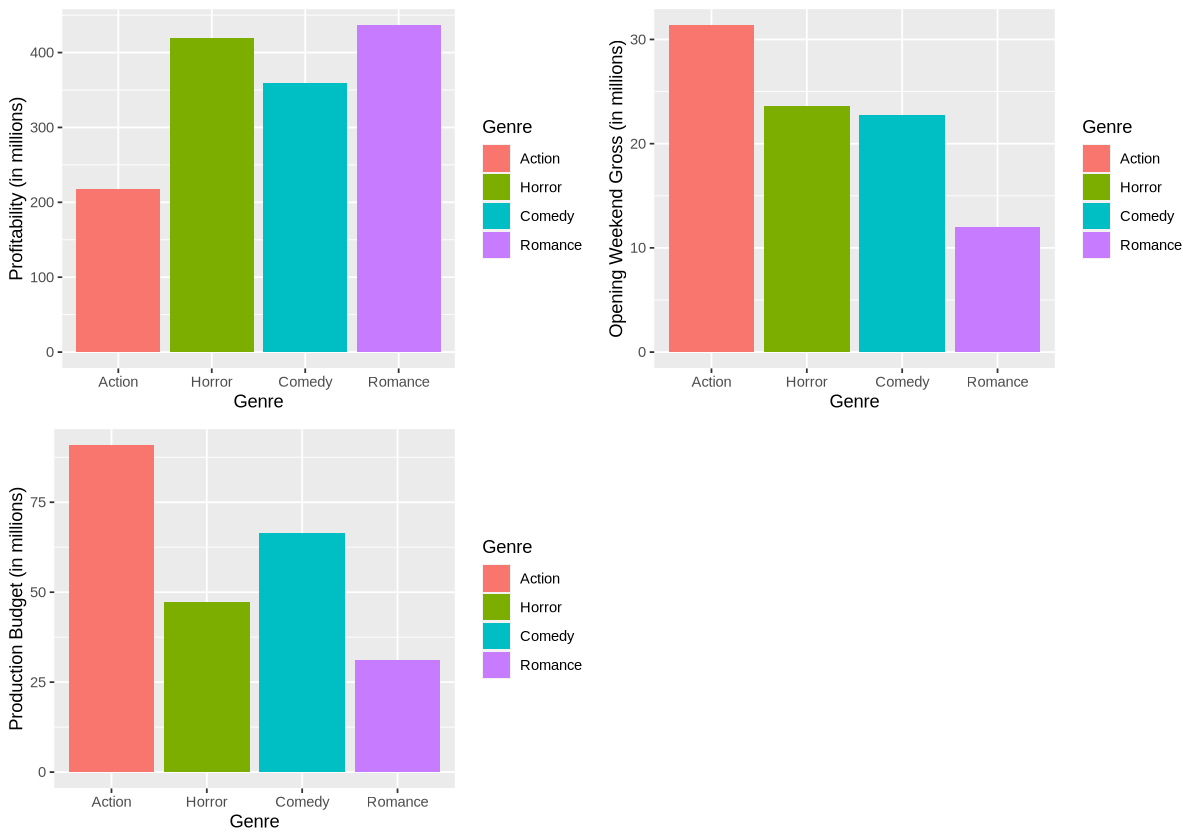

In [20]:
options(repr.plot.width = 10, repr.plot.height = 7) 

genre_profitability_plot <- hollywood_testing_summary |> ggplot(aes(x = Genre, y = ProfitabilityAvg, fill = Genre)) +
    geom_bar(stat = "identity") +
    xlab("Genre")+
    ylab("Profitability (in millions)") 

genre_openingweekend_plot <- hollywood_testing_summary |> ggplot(aes(x = Genre, y = OpeningWeekendAvg, fill= Genre)) +
    geom_bar(stat = "identity") +
    xlab("Genre") +
    ylab("Opening Weekend Gross (in millions)")

genre_productionbudget_plot <- hollywood_testing_summary |> ggplot(aes(x = Genre, y = BudgetAvg, fill= Genre)) +
    geom_bar(stat = "identity") +
    xlab("Genre") + 
    ylab("Production Budget (in millions)")

grid.arrange(genre_profitability_plot, genre_openingweekend_plot, genre_productionbudget_plot, ncol = 2, nrow=2)

**Figure 3**. The barplots above provides a visualization of the average of the predictor variables: production budget, profitability, and opening weekend gross (all in millions) within each genre.

### Methods:

To conduct this data analysis, the plan is to use the k nearest neighbors algorithm for classification problems to predict the genre of a movie based on the opening weekend gross (OpeningWeekend), Production Budget (Budget) and its WorldGross/Budget (Profitability). To solve balancing and missing data problems, any instance in which the genre is NA for a row will be factored out, and the genres will be grouped into the following categories. Additionaly, for missing values in the columns of Budget, Profitability and OpeningWeekend, the impute mean and balancing steps will be added to the program. (Note that not all genres included in the dataset are included in these categories, as some of them were more difficult to group or had too little data.) <br>

Genres are group into the following 4 classes:
- Action/Adventure/Fantasy
- Romance/Drama 
- Horror/Thriller/Mystery/Crime
- Comedy/Musical/Animation

To visualize the results of our prediction, a scatterplot which shows all the different genres in different colors and shapes will be used. The new observation can then be input into the scatterplot to show visually where the closest neighbors are. For clearness, we can also print a line of text that gives you the specific genre the movie was classified as.  

### KNN Classification
Conducting KNN classification so predictions can be made

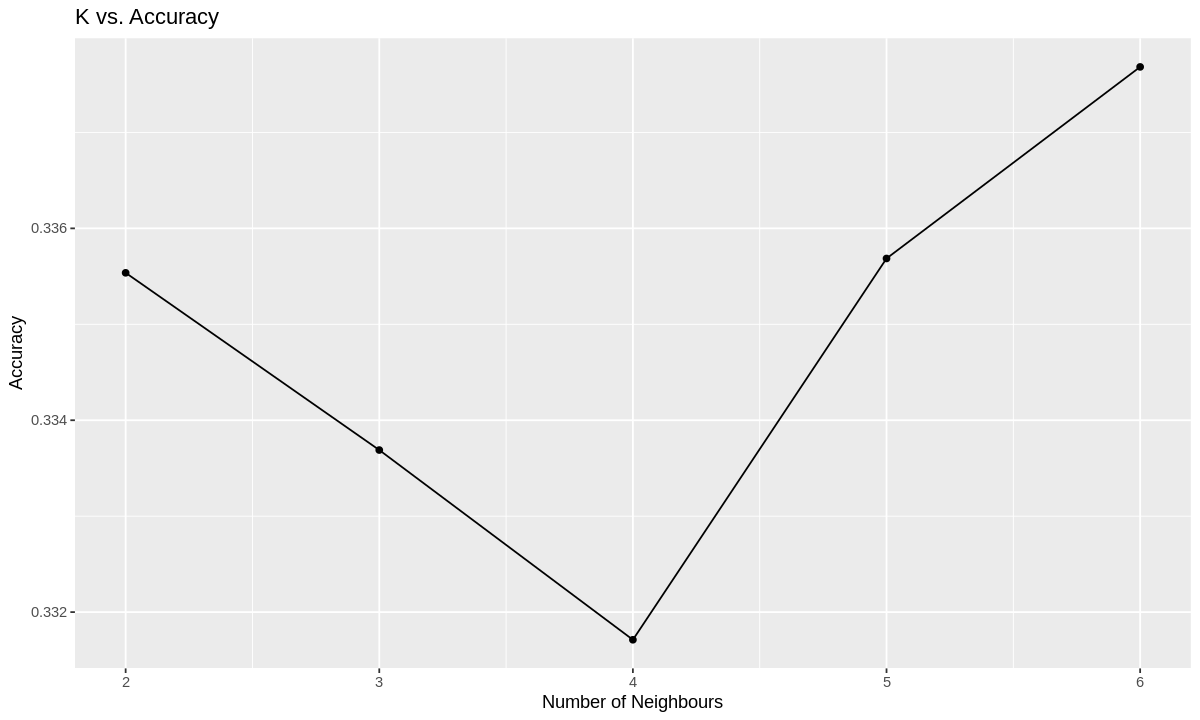

In [15]:
# using knn tune to determine the best k value to use for classification

hollywood_recipe <- recipe( Genre~ ., data = hollywood_training) 

knn_tune<- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
       set_engine("kknn") |>
      set_mode("classification")

num_vfold<- vfold_cv(hollywood_training, v = 5, strata = Genre)

gridvals<- tibble(neighbors = seq(from =2, to = 6, by =1)) 

hollywood_results <- workflow() |>
       add_recipe(hollywood_recipe) |>
       add_model(knn_tune) |>
       tune_grid(resamples = num_vfold, grid = gridvals) |>
       collect_metrics() |>
        filter(.metric== "accuracy")

cross_val_plot<- hollywood_results |> ggplot(aes(x= neighbors, y= mean)) +
    geom_point() +
    geom_line() +
    xlab("Number of Neighbours") +
    ylab("Accuracy") +
    ggtitle("K vs. Accuracy")

cross_val_plot

In [16]:
#build our final model using the best k

hollywood_final_recipe <- recipe(Genre ~ ., data = hollywood_training) 

hollywood_final_spec<- nearest_neighbor(weight_func = "rectangular", neighbors = 4) |>
       set_engine("kknn") |>
      set_mode("classification")

hollywood_final_fit <- workflow() |>
       add_recipe(hollywood_final_recipe) |>
       add_model(hollywood_final_spec) |>
        fit(data= hollywood_training)

hollywood_final_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(4,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.6390041
Best kernel: rectangular
Best k: 4

In [19]:
#testing our final model on our testing data set

hollywood_predictions<- hollywood_final_fit |>
    predict(hollywood_testing) |>
    bind_cols(hollywood_testing)

hollywood_metrics<- hollywood_predictions |>
         metrics(truth = Genre, estimate = .pred_class)

hollywood_metrics

hollywood_conf_mat<- hollywood_predictions |> 
       conf_mat(truth = Genre, estimate = .pred_class)

hollywood_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.3641975
kap,multiclass,0.1112650


          Truth
Prediction Action Comedy Horror Romance
   Action      24     23     12       8
   Comedy      18     20      5       9
   Horror       4      5      7       4
   Romance      4      8      3       8

In [ ]:
#plotting our model

### Expected Outcomes and Significance:

Based on the dataset, we predict that the action/adventure films will have a higher budget, but also higher profitability and opening weekend success. In addition, that biography/documentary films will have a lower profitability and opening weekend success, with a medium budget. The other genre groups are predicted to be seen in the middle range, impacting how films are grouped into their genre.

The findings could be used by the producing studios to plan movies (based on genre) for the intended budget, high profitability, and to ensure success at the opening weekend. Using the knn classification algorithm, the intended budget and hoped profitability/opening weekend success can be used to predict, and ultimately plan the genre of the next film. 

This proposed project could lead to many future questions (through the inclusion of other aspects of the dataset), including:

- Can the model created be applied to films outside Hollywood (in other regions of the globe), tv shows, and other forms of media?
- If the films are sequels, and this was considered in the model, how would this impact the predictions made?
- Are there any clear biases in the model created? 
- How does the studio producing the film relate to the predicted genre?
- Can the genre be selected through both minimizing the budget, and maximizing profitability?

Ultimately, we feel that this model can provide as a base for film planning, but it will also lead to further complications/considerations that should be added to improve its classification and accuracy when making predictions. It will be important for us to consider whether the selected columns and values intended to predict genre are sufficient.

